# Second approach
*08-Oct-21* 

## A.  Mimicing the Dirac $\delta$-function, with $2\epsilon$

This notebook suggests a different apprach to replicate the Dirac $\delta$-function, where the diffusion across the $x$ direction is permitted in a narrow band of thickness $2\epsilon$. 


The motion along such two-dimensional comb structure can be simulated by the following coupled Langevin equations 


<br>

\begin{align}
& x(t+\Delta t)=x(t)+r \beta_x \,\zeta_{x}(t),\\
& y(t+\Delta t)=y(t)+\beta_y\,\zeta_{y}(t),
\end{align}

<br>


where $\beta_x=\sqrt{2D_x \Delta t}$, $\beta_y=\sqrt{2D_y \Delta t}$, $\zeta_{i}(t)$ ($i=\{x,y\}$) are white Gaussian noise with zero mean $\langle\zeta_{i}(t)\rangle=0$, and correlation $\langle\zeta_{i}(t)\zeta_{i}(t')\rangle=\delta(t-t')$. 


<br>


The constant $r$ is 1 only if $|y(t)|<\epsilon$ (hence the $2\epsilon$, for that area around $x=0$), every where else is 0. 

## B. Modeling the dimensions 

Main function for 2D trajectories: 

In [51]:
# author: Viktor Domazetoski
import plotly
import plotly.graph_objs as go
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import numpy as np

plotly.offline.init_notebook_mode()

tmax = 10_000

def comb2d_traj(i=1,betay=.1,betaz=.1,eps=.1):
    r = np.zeros((tmax,2))
    
    for t in range(tmax-1):

        if (np.abs(r[t][1]) <= eps):
            r[t+1][0] = r[t][0] + betay*np.random.normal()
        else:
            r[t+1][0] = r[t][0]
            
        r[t+1][1] = r[t][1] + betaz*np.random.normal()
    
    return(r)

Run a simulation: 
- $time = 10^4$ - total time of simulation 
- $\Delta t = 1$ - change in time (interval size)
- $\sqrt{2\mathcal{D}_x \Delta t} = \beta_x=0.1 \rightarrow$ For $\Delta t=1,  \mathcal{D}_x=0.005$
- $\sqrt{2\mathcal{D}_y \Delta t} = \beta_y=0.1 \rightarrow$ For $\Delta t=1,  \mathcal{D}_y=0.005$
- $\epsilon = 0.1$ - used to mimic the space around $x=0$

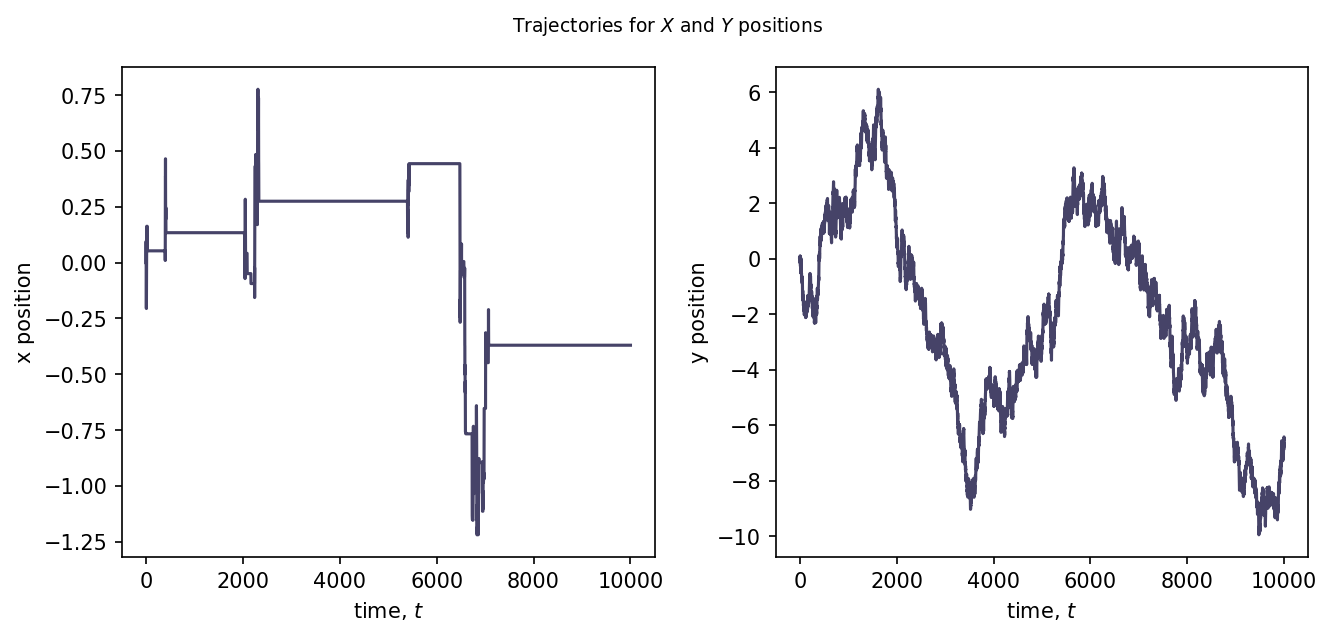

In [56]:
# Matplotlib code
r = comb2d_traj()
time = np.arange(1,tmax+1,1)
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), dpi=150)

plt.suptitle(r"Trajectories for $X$ and $Y$ positions", fontsize=9, y=1.05)

ax1.plot(time, r.T[0], color="#464368")
ax1.set_xlabel(r'time, $t$')
ax1.set_ylabel(r'x position')

ax2.plot(time, r.T[1], color="#464368")
ax2.set_xlabel(r'time, $t$')
ax2.set_ylabel(r'y position')

plt.tight_layout()
ax1.tick_params(direction="in", which='minor', length=1.5, top=True, right=True)
plt.show()

### Results

2D comb random walk:

In [58]:
# Plotly code

from plotly.offline import plot, iplot, init_notebook_mode
from IPython.core.display import display, HTML
init_notebook_mode(connected = True)
config={'showLink': False, 'displayModeBar': False}

trace = go.Scatter(
    x=r.T[0],
    y=r.T[1],
    mode='lines',
    name="Trajectories-comb",
    opacity=0.8, 
    hovertemplate =
    '<i>Y</i>: %{y:.1f}'+
    '<br><i>X</i>: %{x:.1f}<br>',
    line=dict(color="#464368", 
              width=2))

layout = go.Layout(title="2D backbone random walk",
                   title_x=0.5,
    margin={'l': 50, 'r': 50, 'b': 50, 't': 50},
    autosize=False,
    width=420,
    height=400,
    xaxis_title='X',
    yaxis_title='Y',
    plot_bgcolor='#fff',
    yaxis=dict(mirror=True,
                ticks='outside', 
                showline=True,
                showspikes = False,
                linecolor='#000',
               tickfont = dict(size=11)),
    xaxis=dict(mirror=True,
                ticks='outside',
                showline=True,
                linecolor='#000',
                tickfont = dict(size=11))
)

data = [trace]

figa = go.Figure(data=data, layout=layout)


plot(figa, filename = 'fig2_a.html', config = config)
display(HTML('fig2_a.html'))

## C. Mean square displacement 

The returning probability of the Brownian particle from the finger to the backbone corresponds to the waiting time PDF for the particle moving along the backbone, so for Brownian motion it scales as $\sim t^{-3/2}$. From the CTRW theory we know that such waiting times leads to anomalous diffusion with MSD given by $\langle x^{2}(t)\rangle\sim t^{1/2}$. 

Run ensemble, $n = 10^4$ processes

In [16]:
from multiprocessing import Pool

ensemble_size = 10**4
pool = Pool()
ensemble = pool.map(comb2d_traj, range(ensemble_size))
pool.terminate()

Shape of ensemble: 

In [17]:
np.shape(np.concatenate(([[ensemble[i][:,0]] for i in range(ensemble_size)])).T)

(10000, 10000)

Calculate the MSD for both axis: 

In [59]:
# Calculate MSD for X
msd_x = []

for t in range(len(time)):
  value_x = [ensemble[i][t][0] for i in range(ensemble_size)] 
  value = np.dot(value_x, value_x) / ensemble_size    # dot product / ensemble size
  msd_x.append(value)

# Calculate MSD for Y
msd_y = []

for t in range(len(time)):
  value_y = [ensemble[i][t][1] for i in range(ensemble_size)] 
  value = np.dot(value_y, value_y) / ensemble_size    # dot product / ensemble size
  msd_y.append(value)

# Convert to arrays
msd_x = np.array(msd_x)
msd_y = np.array(msd_y)

### Results

##### $\langle x^{2}(t)\rangle\sim t^{1/2}$

In [60]:
# Theoretical vs. Ensemble - MSD X
figure, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)

Dx = Dy = 0.005
factor = 2*Dy/(2*Dx**0.5)
factor

ax.plot(time, (lambda x: 2*Dx*x**0.5)(time), linewidth=0.7, alpha=0.9, label=r"Theory, $t^{1/2}$", color="#2C2891")
ax.plot(time, msd_x, '#FB9300',  markersize=1, linewidth=0.7, alpha=0.9, label=r"Simulation", markevery=30)


ax.set_xlabel(r'Тime, $t$')
ax.set_xscale('log')

ax.set_ylabel(r'$\langle y^2(t) \rangle$)')
ax.set_yscale('log')


plt.legend(loc='upper left',
           fancybox=True,
           shadow=True,
           fontsize='x-small')

plt.ylabel(r"$\langle x^2(t) \rangle$")
plt.xlabel(r"time, $t$")
plt.title(r"MSD; $\langle x^2(t)\rangle=2 \mathcal{D}_x t^{1/2}$", fontsize=9, pad=10)
plt.tight_layout()
plt.show()

##### $\langle y^{2}(t)\rangle\sim t^{1}$

In [62]:
# Theoretical vs. Ensemble - MSD Y
figure, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)

ax.plot(time, (lambda x: 2*Dy*x**1)(time), linewidth=0.7, alpha=0.9, label=r"Theory, $t^1$", color="#2C2891")
ax.plot(time, msd_y, '#FB9300',  markersize=1, linewidth=0.7, alpha=0.9, label=r"Simulation", markevery=30)


ax.set_xlabel(r'Тime, $t$')
ax.set_xscale('log')

ax.set_ylabel(r'$\langle y^2(t) \rangle$)')
ax.set_yscale('log')


plt.legend(loc='upper left',
           fancybox=True,
           shadow=True,
           fontsize='x-small')

plt.ylabel(r"$\langle y^2(t) \rangle$")
plt.xlabel(r"time, $t$")
plt.title(r"MSD; $\langle y^2(t)\rangle=2 \mathcal{D}_y t^{1}$", fontsize=9, pad=10)
plt.tight_layout()
plt.show()